# `AA Workshop 07` - Linear Classification

In this workshop we will dive into classification. Classification is the prediction of classes. This means our target variable can take only a set of discrete values (versus the continuous case for regresssion). 

We will cover the following: 
1. Introduction to Linear Classification
1. Linear Classification Using Support Vector Machines
1. Evaluating Classification Models

---

## Introduction to Linear Classification

### From Regression to Classification

Whereas our previous introduction to machine learning focused on the case of predicting real-valued outputs (called the regression setting), these notes consider the case of predicting discrete-valued outputs. This is called the classification setting. And while it may seem as though this would require very different techniques to handle (after all, the regression setting we just considered made very "continuous" predictions rather than discrete ones), one nice thing about our generic framework for machine learning is that in reality, there is very little difference between how we handle regression and classification problems. Like before, there are hypothesis functions, loss functions, and our goal is still to solve the canonical problem of minimizing the sum of losses on a data set (the only real difference is in the choice of loss function, as we will see even the hypothesis class largely remains the same).

Let us first consider a very simple illustrative example...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

np.set_printoptions(suppress=True) # suppress scientific notation
%matplotlib inline

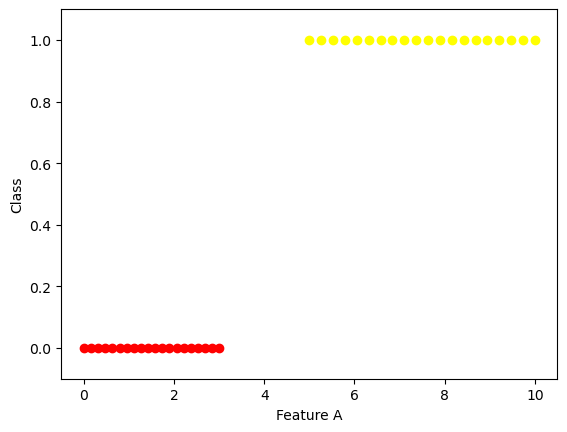

In [2]:
# create illustrative data
x1 = np.linspace(0, 3, 20)
x2 = np.linspace(5, 10, 20)
y1 = np.zeros(20)
y2 = np.ones(20)

plt.scatter(x1, y1, c='red')
plt.scatter(x2, y2, c='yellow')
plt.xlabel("Feature A")
plt.ylabel("Class")
plt.ylim(-0.1,1.1)
plt.show()

Imagine we have a dataset with only a single feature A and two classes, namely red and yellow. For larger values of feature A, it appears that observations are more likely to belong to class yellow. A linear classifier would attempt to draw a straight line separating the two classes. For this one-dimensional case, this is something we could do by hand.

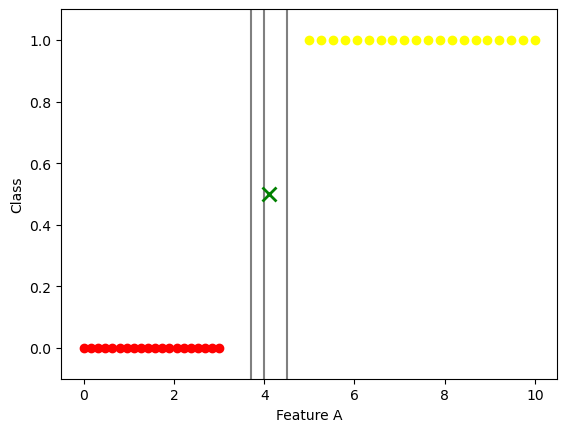

In [3]:
# create illustrative data
x1 = np.linspace(0, 3, 20)
x2 = np.linspace(5, 10, 20)
y1 = np.zeros(20)
y2 = np.ones(20)

plt.scatter(x1, y1, c='red')
plt.scatter(x2, y2, c='yellow')
plt.plot([4, 4], [-0.1, 1.1], color='grey')
plt.plot([4.5, 4.5], [-0.1, 1.1], color='grey')
plt.plot([3.7, 3.7], [-0.1, 1.1], color='grey')
plt.plot([4.1], [0.5], 'x', color='green', markeredgewidth=2, markersize=10) # add a new datapoint illustrating a new observation
plt.xlabel("Feature A")
plt.ylabel("Class")
plt.ylim(-0.1,1.1)
plt.show()

However, you might notice one problem: where exactly should we draw the line? This question is quite relevant, as you can see by considering a new observation (represented by the green X). Depending on the chosen line, we would classify this observation as either red or yellow. Also realize how the line we are searching for here is different from the line we were fitting in linear regression. **Instead of "fitting a line to the data", we are now "separating the classes with a line".**


Let us now move on and pretend we have two features, namely A and B, instead of one.

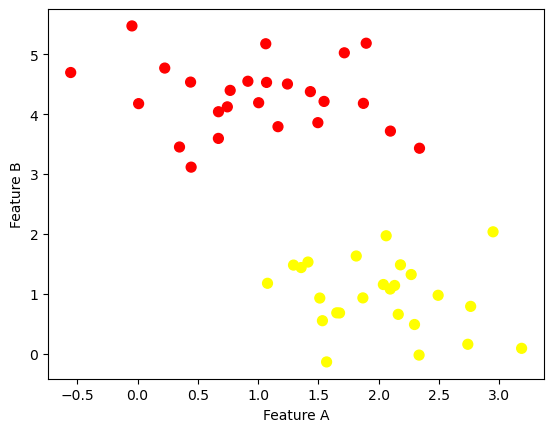

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.xlabel("Feature A")
plt.ylabel("Feature B")
plt.show()

Again, we can see that Features A and B provide information on class affiliation. A linear discriminative classifier would attempt to draw a straight line (or hyperplane for that matter) separating the two sets of data, and thereby create a model for classification. For two-dimensional data like that shown here, we could still do this by hand. The problem, however, remains: there is more than one possible separating boundary that can perfectly discriminate between the two classes!

We can draw them as follows:

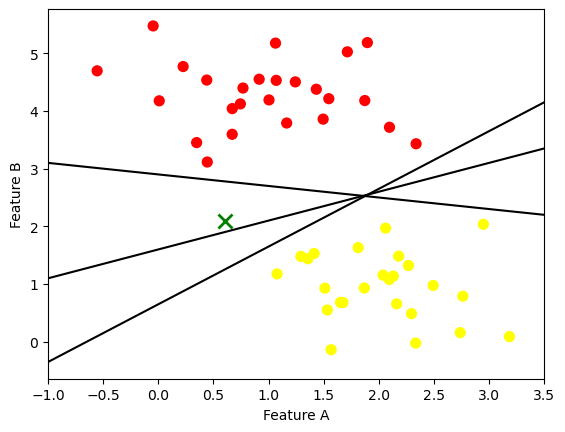

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='green', markeredgewidth=2, markersize=10) # add a new datapoint illustrating a new observation

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlabel("Feature A")
plt.ylabel("Feature B")
plt.xlim(-1, 3.5)
plt.show()

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Again, notice how "drawing a line" is different in this classification setting from fitting a linear regression line as we used to before.

### Illustrative Example: Breast Cancer Classification

As an example to introduce classification problems, we're going to turn to a classical example from the machine learning literature, first presented in [[Street et al, 1993]](https://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/WDBC/), namely identifying whether cancer cells from a biopsy are malignant or benign.  This was historically an important dataset in the intersection of machine learning and health care, and similar subjects are still a topic of very active research.  Of course, 25 years ago, the techniques were much more primitive and computationally less intensive than current approaches to similar problems, but the work has become a classical dataset in machine learning, and also represents a compelling applications.

To create the data set, researchers took 569 images of cancerous cells, under a microscope, and manually selected the outlines of the different cells (this step is the kind of thing that would ideally be replaced by automatic computer vision architectures in current systems).  The resulting figures looked like this:

![Image of (manually) selected outlines of cells under a microscope.](cancercells.png)

The researchers then considered 10 different features of each cell, for instance the area, perimeter, texture, number of concave points (i.e., indentations), variance of grayscale color, and some others (a full list can be found in the above paper).  For each of these 10 features they computed the mean, max, and standard deviation of the feature across all the cells in the image, resulting in a 30 dimensional vector describing each sample.

In [6]:
cancer_df = pd.read_csv("../data/breast_cancer.csv", index_col = "id")
print("Number of benign samples:", len(cancer_df[cancer_df["diagnosis"]=="B"]))
print("Number of malignant samples:", len(cancer_df[cancer_df["diagnosis"]=="M"]))

Number of benign samples: 357
Number of malignant samples: 212


In [7]:
cancer_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Let us first plot a single feature, namely `area_mean`, and see how the results differ for **malignant** and **benign** tumors:

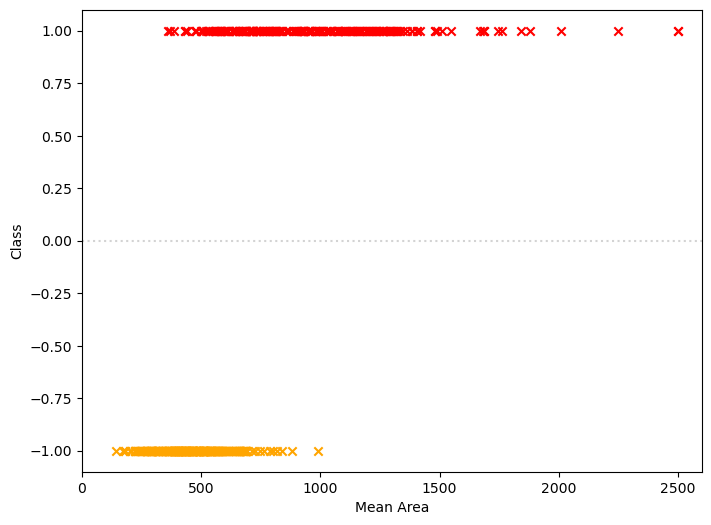

In [8]:
# this function scales class_membership so that M equals 1 and B equals -1
def rescale_classes(class_membership, true_label='M'):
    return (class_membership == true_label).astype(int) * 2 - 1

# this function plots the samples
def plot_cells(variable='area_mean'):
    plt.figure(figsize=(8,6))
    malign = cancer_df[cancer_df["diagnosis"]=="M"]
    benign = cancer_df[cancer_df["diagnosis"]=="B"]
    plt.scatter(benign[variable], rescale_classes(benign['diagnosis']), marker='x', color='orange')
    plt.scatter(malign[variable], rescale_classes(malign['diagnosis']), marker='x', color='red')
    plt.plot([0, 2600], [0,0], color='lightgrey', linestyle='dotted')
    plt.xlim([0,2600])
    plt.ylim([-1.1,1.1])
    plt.xlabel("Mean Area")
    plt.ylabel("Class")
    
plot_cells()

In order to classify the tumors based on their mean area, let us first stick with what we know: linear regression. With linear regression, we can fit a line that aims to predict -1 or 1 for each tumor using a squared error as loss function.

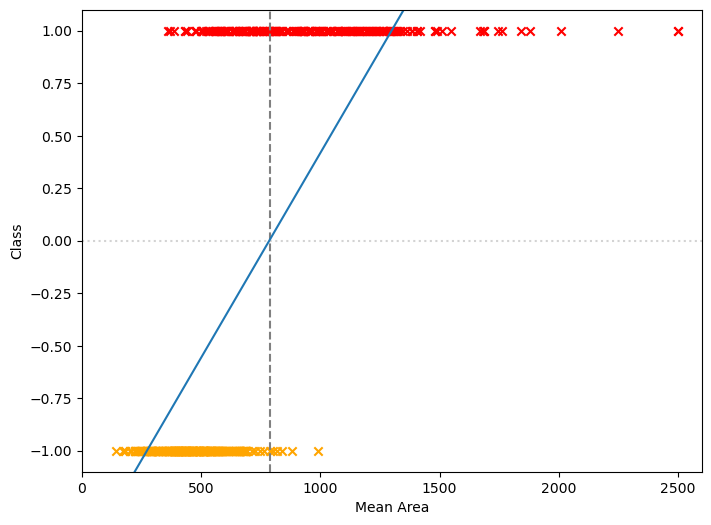

In [9]:
# define x and y
x = cancer_df['area_mean'].values.reshape(-1,1)
y = rescale_classes(cancer_df['diagnosis'])

# fit model
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression(fit_intercept=True)
linear_reg.fit(x, y)

# plot
plot_cells()
xfit = np.linspace(0, 2600)
plt.plot([790, 790], [-1.1, 1.1], color='grey', linestyle='--')
plt.plot(xfit, linear_reg.predict(xfit.reshape(-1,1)))
plt.show()

The blue line plots the hypothesized values. Note how we can derive our separating boundary (the grey dashed line): it is located at the point for which our linear regression predicts precisely 0, i.e. the point where we would not know whether to predict if this is a malignant or benign tumor.

**Question**: What do you think about our classification model? Is this the optimal separating boundary? Do you see any problems?

### Alternative Loss Functions for Classification

As we have seen above, our beloved mean squared error does not seem to be a great choice of a loss function in a classification setting. Luckily, we have other options at our disposal. There are many such losses, and different choices lead to different machine learning algorithms (often with very little indication that all that differs between the algorithm is in fact the choice of loss function).  Let's consider a few of the more common ones:

- **0/1 loss:** 
\begin{equation}
\ell_{\mathrm{0/1}}(h_\theta(x), y) = 
      \begin{cases}
      0 & \text{if sign $h_\theta(x) = y$}\\
      1 & \text{otherwise}
      \end{cases}
\end{equation}
Major disadvantage: function is non-smooth and therefore cannot be used with algorithms like gradient descent.

- **Logistic loss:** 
\begin{equation}
\ell_{\mathrm{logistic}}(h_\theta(x), y) = \log(1+\exp(-h_\theta(x) \cdot y))
\end{equation}
For large positive values of $h_\theta(x) \cdot y$, $\exp(-h_\theta(x) \cdot y)$ will be very close to zero, so the loss will approach zero; for large negative values $\log(1+\exp(-h_\theta(x) \cdot y)) \approx -h_\theta(x) \cdot y$ so the loss increases approximately linearly.

- **Hinge loss:**
\begin{equation}
\ell_{\mathrm{hinge}}(h_\theta(x), y) = \max\{1 - h_\theta(x) \cdot y, 0\}
\end{equation}
As long as $h_\theta(x) \cdot y \geq 1$, this loss will be zero, whereas it will increase linearly for negative $h_\theta(x) \cdot y \geq 1$.

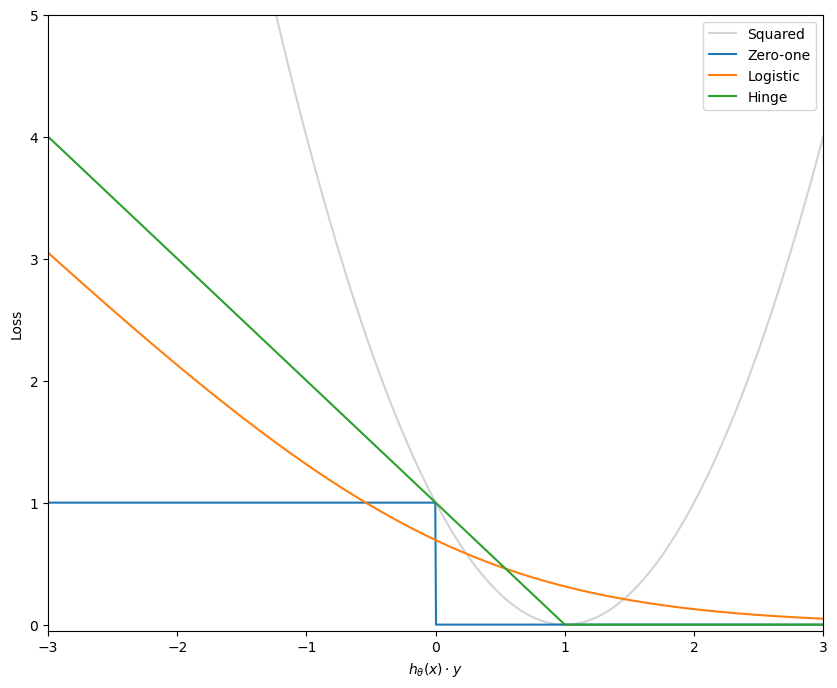

In [10]:
hy = np.linspace(-3,3,1000)
plt.figure(figsize = (10,8))
plt.plot(hy, np.square(hy-1), c="lightgrey")
plt.plot(hy,(hy<=0))
plt.plot(hy, np.log(1+np.exp(-hy)))
plt.plot(hy, np.maximum(1 - hy, 0))

plt.xlim([-3,3])
plt.ylim([-0.05, 5])
plt.ylabel("Loss")
plt.xlabel("$h_θ(x) \cdot y$")
plt.legend(['Squared', 'Zero-one', 'Logistic', 'Hinge'])
plt.show()

---

## Solving Linear Classification Tasks with Support Vector Machines

With this framework and set of loss functions laid out, the task of learning a classifier is exactly the same as the regression methods we considered previously.  That is, given a data set we seek to minimize the average loss
\begin{equation}
\min_{\theta} \frac{1}{m}\sum_{i=1}^{m} \ell(h_{\theta}(x^{(i)}),y^{(i)})
\end{equation}

Unlike regression, there is virtually no setting (except, of course, just using least-squares loss) where there is an analytical solution to this optimization problem.  Nonetheless, we can still solve it by resorting back to gradient descent (there are alternative optimization approaches for most of these problems, but we'll only cover gradient descent).  To see how this works, we'll next consider a specific machine learning algorithm in detail: support vector machines.

Support vector machines (SVMs) result from choosing hinge loss
\begin{equation}
\ell_{\mathrm{hinge}}(h_\theta(x),y) = \max \{1-h_\theta(x)\cdot y, 0\}
\end{equation}
as the loss function to minimize.  If you have seen support vector machines before, you may have seen them explained in a geometric context, illustrating that they maximize the "margin" of separation between examples of different classes.  This is true, and support vector machines absolutely can be viewed this way.  But it is also instructive to simply understand them as minimizing the particular loss function above.

Support vector machines also refer either to a linear hypothesis function, or a particular form of nonlinear hypothesis known as a _kernel_ hypothesis (we will get to this in the next workshop); if you ever hear the terms "linear SVM" or "kernel SVM", this is just the designation of which type of hypothesis function they are using.  That is, linear SVMs use the hypothesis function
\begin{equation}
h_\theta(x) = \sum_{j=1}^n \theta_j x_j = \theta^T x,
\end{equation}


To illustrate, let us first add a second feature of the breast cancer dataset: in addition to `area_mean`, we now also consider `concave points_mean` and see how the results differ for **malignant** and **benign** tumors:

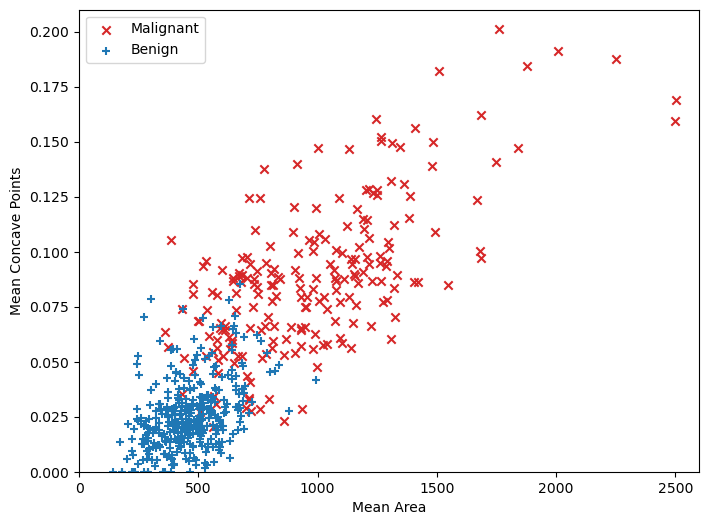

In [11]:
def plot_cells(x='area_mean',y='concave points_mean'):
    plt.figure(figsize=(8,6))
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='M'][x], cancer_df[cancer_df["diagnosis"]=='M'][y], marker='x', color='C3')
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='B'][x], cancer_df[cancer_df["diagnosis"]=='B'][y], marker='+', color='C0')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend(['Malignant','Benign'])
    
plot_cells()

There is obviously some structure to the data here: cells with greater average area and greater numbers of concave points are more likely to be malignant. Remember that we are still trying to find the optimal separating boundary:

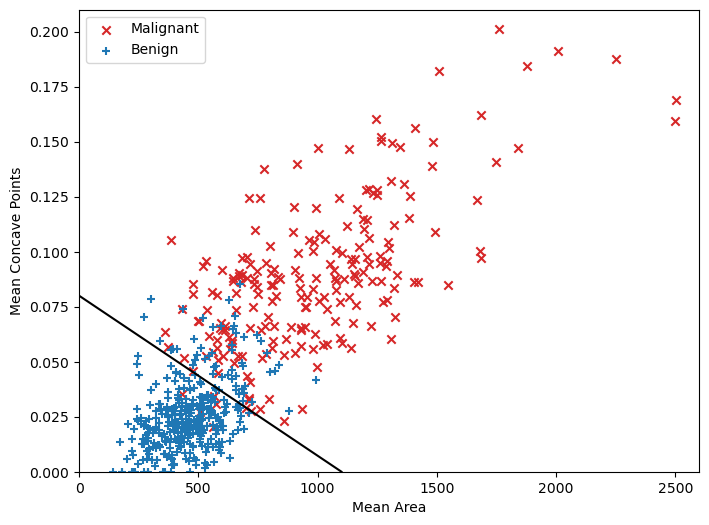

In [12]:
plot_cells()
plt.plot([0, 1100], [0.08,0], 'k-') # we manually fit a line here by defining the intercepts with the x- and y-axis
plt.show()

Just as our linear regression line did not pass exactly through all the data points, here, we can't achieve a line that exactly separates all the data points. But there is clearly a structure in which points below the line are "more likely" to be benign, and points above the line are "more likely" to be malignant.

### SVM Intuition: Maximizing the Margin

Let's again gain a basic understanding of what using a Hinge loss function means graphically. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest points (which are called the support vectors). Here is an example of how this might look:

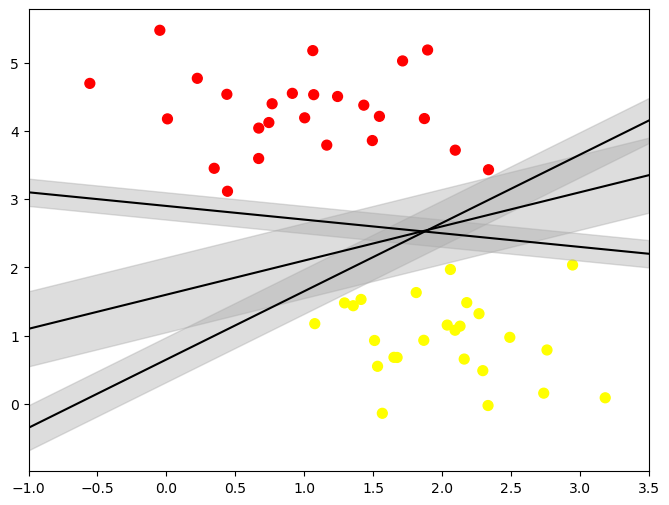

In [13]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize=(8,6))
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)
plt.show()

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.

### Fitting a Support Vector Machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on breast cancer data. We will use sklearn's `LinearSVC` class. Alternatively, you could also use the `SVC` class.

The scikit-learn library, which we previously discussed in the context of regression, also has built-in algorithms for classification. Using these again just requires the initialization, `.fit()`, and `.predict()` methods, with the additional note that if you want the actual output of the hypothesis function, you need to use the `.decision_function()` call.

We also consider here the scikit-learn way of normalizing features.  This is done via the `sklearn.preprocessing.StandardScaler` class. It has a similar interface as the machine learning classes, with a similar method `.fit()` (which computes the mean and variance of a column), and `.transform()` (which converts the data to have zero mean and unit variance). Let's see how this class works.

In [14]:
X = np.array(cancer_df[['area_mean','concave points_mean']])
Y = cancer_df['diagnosis'].values

We again normlize our features using the StandarScaler class in scikit learn.

In [15]:
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()
X_norm = norm.fit_transform(X)  # simultaneously fit and transform 

**Recall**: StandardScaler normalizes to 0 mean and unit variance

In [16]:
print("Mean and standard deviation of Non-normalized X: ", np.mean(X, axis=0), np.std(X, axis=0))
print("Mean and standard deviation of normalized X: ", np.mean(X_norm, axis=0),np.std(X_norm, axis=0))

Mean and standard deviation of Non-normalized X:  [6.54889104e+02 4.89191459e-02] [3.51604754e+02 3.87687325e-02]
Mean and standard deviation of normalized X:  [-2.18532476e-16 -4.99502802e-17] [1. 1.]


In [17]:
from sklearn.svm import LinearSVC

model_SVM = LinearSVC(loss='hinge')
model_SVM.fit(X_norm, Y)  # Note: There is no need to encode Y. The algorithm does that automatically

,penalty,'l2'
,loss,'hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [19]:
def plot_classification_sklearn(model, norm):
    x_range = [0,2600]
    y_range = [0, 0.21]
    plt.figure(figsize = (10,8))
    
    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),  # create coordinate mesh
                        np.linspace(y_range[0], y_range[1], grid))
    
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(norm.transform(X_)).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C0')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C3')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2],['Malignant', 'Benign'])

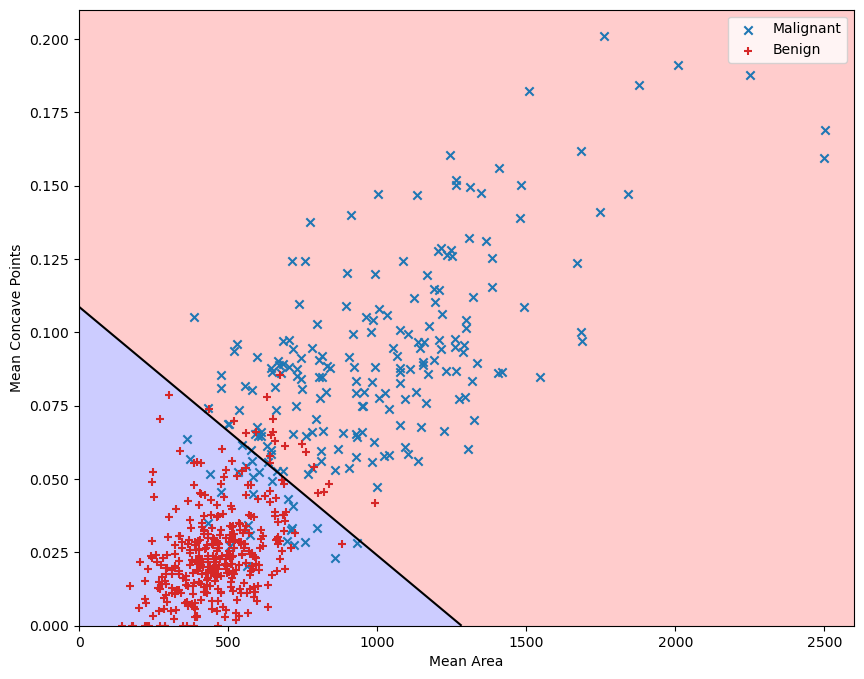

In [20]:
plot_classification_sklearn(model_SVM, norm)

How well does SVM Classification perform? Let us look at accuracy.

In [21]:
(model_SVM.predict(X_norm) == Y).mean()  # Note: mean() operation on booleans returns the proportion of True

np.float64(0.9173989455184535)

Scikit-learn also provides a shorthand metric function for this: `accuracy_score`

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(Y, model_SVM.predict(X_norm))

0.9173989455184535

---

## Evaluating Classification Models

Just before, we calculated the "accuracy" of our SVM to get an understanding of how well our model works. Let us formalize how to properly evaluate classification models.

### Confusion Matrix

Confusion matrices plot true negatives (TN) and true positives (TP) vs. false negatives (FN) and false positives (FP). What results is a 2x2 matrix that provides an overview of classifier performance. See the [Wikipedia article](https://en.wikipedia.org/wiki/Confusion_matrix) for more info.

Let's check out how this looks like for our simplest case, the linear SVM prediction (`model_SVM`) with two features.

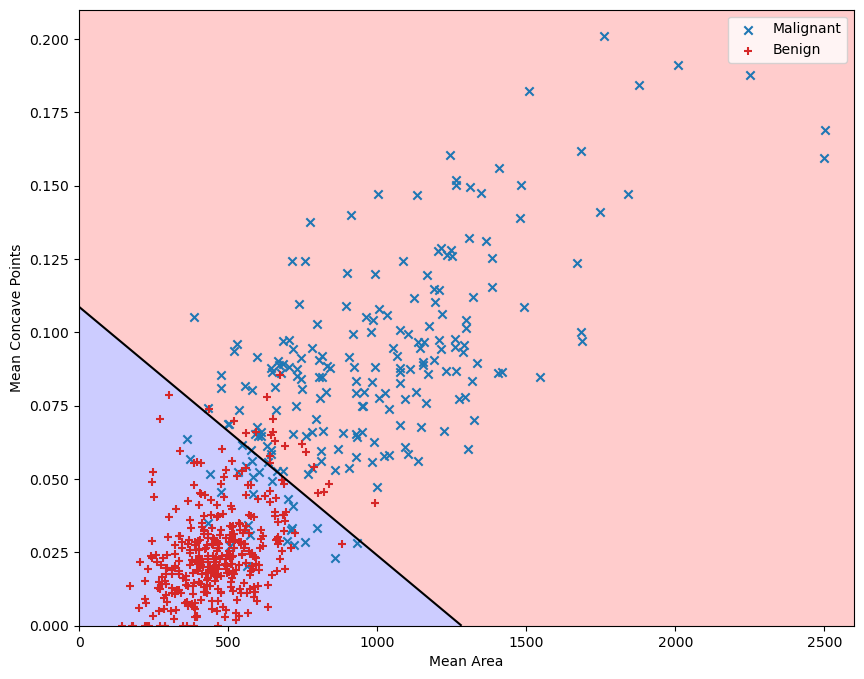

In [23]:
plot_classification_sklearn(model_SVM, norm)

In [24]:
# compute confusion matrix for our SVM model
import sklearn.metrics

confusion_matrix = sklearn.metrics.confusion_matrix(Y, model_SVM.predict(X_norm),labels=["M","B"])
print(confusion_matrix)

[[185  27]
 [ 20 337]]


Rows of the confusion matrix indicate **actual** values, while colums indicate **predicted** values. The `labels` argument allows us to order the confusion matrix. Setting it to `labels = ["M","B"]` ensures that the first row and first colum represent malignant entries. Therefore, we get:

|  | Malignant | Benign |
| --- | --- | --- |
| Malignant | TP | FN |
| Benign | FP | TN |

From this confusion matrix various additional performance metrics can be derived. Let us consider some of the most common ones:

### Accuracy

Accuracy is the ratio of all correctly classified samples vs. the total number of samples. It is computed as follows:

\begin{equation}
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
\end{equation}

The scikit learn implementation is straight forward:

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(Y, model_SVM.predict(X_norm))
print(accuracy_score)

0.9173989455184535


Relating this back to the confusion matrix from above:

In [26]:
(185+337)/sum(sum(confusion_matrix))

np.float64(0.9173989455184535)

### Precision

Precision is the ratio of all correctly classified positive samples vs. the total amount of classified positive samples. It provides the proportion of positive identifications that were actually correct and is computed as follows:

\begin{equation}
Precision = \frac{TP}{TP+FP}
\end{equation}

The scikit learn implementation is as follows:

In [27]:
from sklearn.metrics import precision_score
precision_score = precision_score(Y, model_SVM.predict(X_norm), pos_label="M")
print(precision_score)

0.9024390243902439


Relating this back to the confusion matrix from above:

In [28]:
(185)/(185+20)

0.9024390243902439

### True Positive Rate (Recall)

Recall is the ratio of true positives vs. all actual positives. It is computed as follows:

\begin{equation}
Recall = \frac{TP}{TP+FN}
\end{equation}

The scikit learn implementation is as follows:

In [29]:
from sklearn.metrics import recall_score
recall_score = recall_score(Y, model_SVM.predict(X_norm), pos_label="M")
print(recall_score)

0.8726415094339622


Relating this back to the confusion matrix from above:

In [30]:
(185)/(185+27)

0.8726415094339622

### ROC and Precision-Recall Curves
Two other common evaluation metrics are [ROC curves](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and [precision-recall curves](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html). You can read up about them in the scikit-learn documentation.

In [31]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

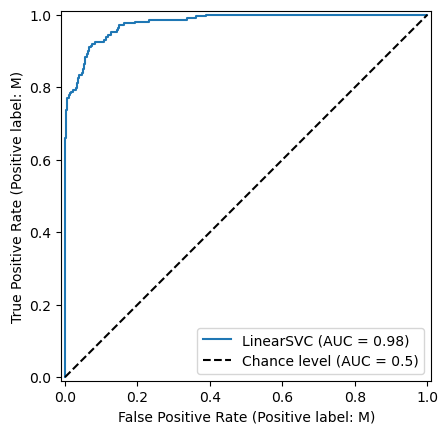

In [32]:
RocCurveDisplay.from_estimator(model_SVM, X_norm, Y, plot_chance_level=True)
plt.show()

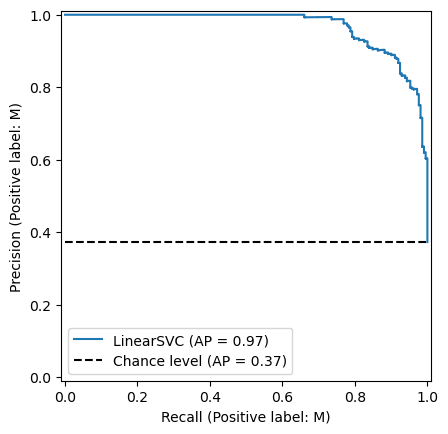

In [33]:
PrecisionRecallDisplay.from_estimator(model_SVM, X_norm, Y, plot_chance_level=True)
plt.show()

**IMPORTANT**: Remember that to properly evaluate a prediction model, we need to perform cross-validation (just like we did in a regression setting).

---